In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial

In [2]:
# setup basic arguments for qed-ci calculation

# z-matrix for LiH
mol_str_LiH = """
Li
H 1 1.546938775510204
symmetry c1
"""

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.005]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}



##  Scan centered around ground state PES minimum

In [3]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 2
}

# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

# array  for energies inside the cavity
cavity_E_array_LiH = np.zeros((N_R, N_el))

r_data = np.linspace(1.0, 3.5, 50)
psi4.set_options(options_dict)
fci_S0 = []
fci_S1 = []
r_idx_LiH = 0
for r in r_data:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))
    LiH_cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_E_array_LiH[r_idx_LiH,:] = LiH_cav.CIeigs[:N_el]
    r_idx_LiH += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Mon Jan 29 14:57:26 2024

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> 

## Scan centered around excited state PES minimum

In [4]:
mol_tmpl_e = """
Li
H 1 **R**
symmetry c1
"""

r_data_e = np.linspace(1.45, 1.95, 50)
psi4.set_options(options_dict)
fci_S0_e = []
fci_S1_e = []
for r in r_data_e:
    mol_str_e = mol_tmpl.replace("**R**", str(r))
    mol_e = psi4.geometry(mol_str_e)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0_e.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1_e.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Mon Jan 29 14:58:08 2024

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> 

## Permanent Dipole Moment Calculations

In [5]:
# z-matrix for ground state LIH
LiH_g_string = """
Li       0.0000000000      0.0000000000      0.0000000000                 
H        0.0000000000      0.0000000000      1.5459183673469388     
symmetry c1
"""

LiH_g = psi4.geometry(LiH_g_string)

psi4.set_options(options_dict)

E, wfn_g = psi4.energy('SCF', return_wfn=True,molecule=LiH_g)
psi4.oeprop(wfn, 'DIPOLE', molecule=LiH_g)


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Mon Jan 29 14:58:15 2024

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> 

In [6]:
# z-matrix for first excited state state LIH
LiH_e_string = """
Li       0.0000000000      0.0000000000      0.0000000000                 
H        0.0000000000      0.0000000000      1.8581632653061224 
symmetry c1
"""

options_dict1 = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'TDSCF_STATES' : 2
}

LiH_e = psi4.geometry(LiH_e_string)

psi4.set_options(options_dict1)

E, wfn_e = psi4.energy('TD-SCF', return_wfn=True, molecule=LiH_e,)
#psi4.oeprop(wfn, 'DIPOLE', molecule=LiH_e)


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Mon Jan 29 14:58:16 2024

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> 

## Calculation of k
Fit ground state PES of H2 to a quintic polynomial

Min on S0 is 1.5612244897959184
Min on S1 is 1.8581632653061224
Min on LP is 1.5612244897959184
Min on UP is 1.7653061224489797
          5          4         3         2
-0.01456 x + 0.1977 x - 1.069 x + 2.847 x - 3.649 x - 6.099
156.30720787318685


<function matplotlib.pyplot.show(close=None, block=None)>

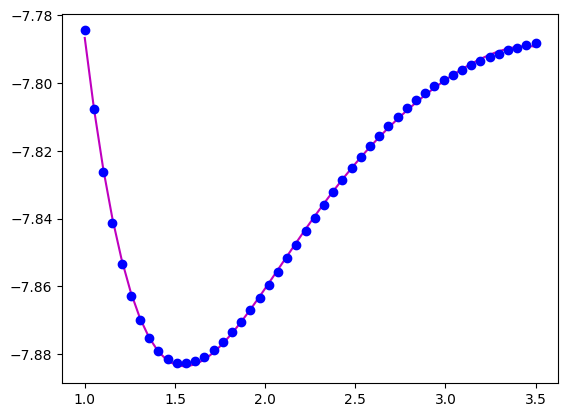

In [31]:
def find_crossover(array1, array2):
    idx = (np.abs(array1 - array2)).argmin()

    return idx
index = find_crossover(cavity_E_array_LiH[:,1], cavity_E_array_LiH[:,2])

UP_array_1 = cavity_E_array_LiH[:index,2]
UP_array_2 = cavity_E_array_LiH[index:,1]
UP_array_full = np.concatenate((UP_array_1, UP_array_2), axis=0)
    
LP_array_1 = cavity_E_array_LiH[index:,2]
LP_array_2 = cavity_E_array_LiH[:index,1]
LP_array_full = np.concatenate((LP_array_2, LP_array_1), axis=0)

au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
min_S0_loc = np.argmin(fci_S0[:])
min_S1_loc = np.argmin(fci_S1_e[:])
min_LP_loc = np.argmin(LP_array_full)
min_UP_loc = np.argmin(cavity_E_array_LiH[:,3])
r_eq_ang = r_data[min_S0_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')
print(f'Min on S1 is {r_data_e[min_S1_loc]}')
print(f'Min on LP is {r_data[min_LP_loc]}')
print(f'Min on UP is {r_data[min_UP_loc]}')

# Fitting S0 PES to a quintic polynomial
poly = np.poly1d(np.polyfit(r_data, fci_S0, 5))
print(poly)

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, fci_S0[:], 'bo', label='cavity free |g>')
plt.show

## Calculation of $ \text{x}_0 $

$$ \frac{\hbar}{2}\sqrt{\frac{k}{\mu}} = \frac{k}{2}(x_0 - x_{eq})^2 + V_0 $$

Expanded, solved for $ x_o $, and found zeros using quadratic formula

In [8]:
mu_amu = 1.00784 * 6.9410 / (1.00784 + 6.9410)
mu_kg = mu_amu  * 10 ** (-3) / (6.022 * 10 ** 23) 
r_eq_SI = r_eq_ang * 10 ** (-10)
h_bar = constants.hbar
V_0_loc = np.argmin(fci_S0)
V_0 = fci_S0[V_0_loc] * 4.35974 * 10 ** (-18)
left = (h_bar / 2) * np.sqrt(k_test_SI / mu_kg)
a = 0.5 * k_test_SI 
b = -k_test_SI * r_eq_SI
c = 0.5 * k_test_SI * (r_eq_SI ** 2) - left
zeros_n = (-b - np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
zeros_p = (-b + np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
x0_angstrom = zeros_n * 10 ** 10
x0_au = x0_angstrom / psi4.constants.bohr2angstroms
print(x0_angstrom)

1.4126818810077573


## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [9]:
# Constants and Variables
delta_au = (r_data_e[min_S1_loc] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms
delta_LP_au = (r_data[min_LP_loc] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms
delta_UP_au = (r_data[min_UP_loc] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms
delta_m = (r_data_e[min_S1_loc] - r_data[min_S0_loc]) * 10 ** (-10)
delta_angstrom = (r_data_e[min_S1_loc] - r_data[min_S0_loc])
omega_vib = np.sqrt(k_test_SI / mu_kg)
h_bar = constants.hbar
x0_test = np.sqrt(h_bar * omega_vib / k_test_SI)
x0_test_au = (x0_test * 10 ** (10))  / psi4.constants.bohr2angstroms

# Turner
S_Turner = 0.5 * (delta_au / x0_test_au) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

#g and LP 

HR_LP = 0.5 * (delta_LP_au / x0_test_au) ** 2
HR_UP = 0.5 * (delta_UP_au / x0_test_au) ** 2

print('|g> and |e> HR Factor')
print(S_Turner)
print(S_Hsu)

print('LP and UP HR Factor')
print(HR_LP)
print(HR_UP)

|g> and |e> HR Factor
1.998028767981035
1.9980287679810342
LP and UP HR Factor
85.17712181494714
0.9437908234343177


## Polaritonic Huang-Rhys Factor

$$ S_{pol} = \frac{|\Delta\mu \epsilon_s|^2}{2\epsilon_0 V_{eff,s} \hbar \omega_s} \tag{Hsu} $$
Where:

$\Delta\mu \equiv \text{Permanant Dipole Difference} = \mu_g - \mu_e$

$\epsilon_s \equiv \text{Unit Vector}$

$V_{eff,s} \equiv \text{Effective Mode Volume}$

$\omega_s \equiv \text{Frequency of a single photonic mode}$

In [10]:
mu_g = 1.9066253 * 3.335 * 10 ** (-30)
mu_e = 1.9450498 * 3.335 * 10 ** (-30)
d_mu_squared = (mu_g - mu_e) ** 2
epsilon_s = 1
epsilon_0 = constants.epsilon_0
lambda_mag = 0.05 #ask about units
V_eff = h_bar / (epsilon_0 * lambda_mag ** 2)  
omega_s = 0.12086  #ask about units
S_pol = d_mu_squared / (2 * epsilon_0 * V_eff * h_bar * omega_s)
print(S_pol)

15271.553829966737


First plot the ground-state potential energy surfaces for $ \text{LiH} $ inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

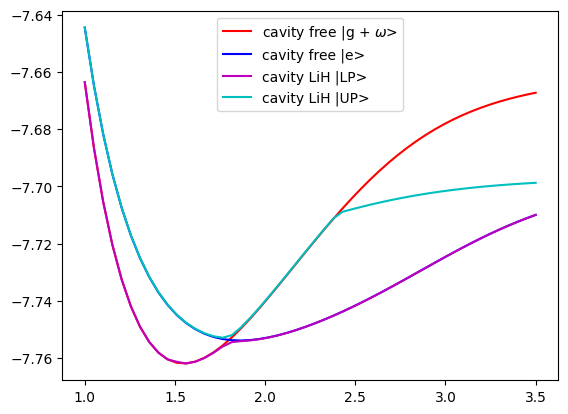

In [32]:
fci_S0_omega = np.zeros((1, 50))
for i in range(50):
    fci_S0_omega[0,i] = fci_S0[i] + 0.12086
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)




plt.plot(r_data, fci_S0_plusw, 'r-', label='cavity free |g + $\omega$>')
plt.plot(r_data, fci_S1, 'b-', label='cavity free |e>')
plt.plot(r_data, LP_array_full, 'm-', label='cavity LiH |LP>')
#plt.plot(r_data, cavity_E_array_LiH[:,1], 'g-', label='cavity LiH |TRIPLET>')
plt.plot(r_data, cavity_E_array_LiH[:,3], 'c-', label='cavity LiH |UP>')
#plt.xlim(1.5, 2)
#plt.ylim(-7.76, -7.72)
plt.legend()
plt.show()
